## Yandex DataSphere Delivery example

**Задача**: доставить Training Job на DataSphere и запустить там.

#### План

* Создать локально TrainingJob со списком task'ов и всей необходимой информацией о датасете

* Запустить локально тем образом, каким будем запускать в DataSphere

* Запустить в DataSphere с помощью Docker, как описано в training_grounds/Delivery.md

### Загрузим бандл на YandexStorage

In [1]:
from sklearn import datasets
import pandas as pd
from tg.common.ml import batched_training as bt


In [2]:
project_name = 'testirisproject'
dataset_name = 'irisdataset'
bucket = 'testirisbucket'


In [3]:
import os
from pathlib import Path
from tg.grammar_ru.common.loc import Loc
from dotenv import load_dotenv
load_dotenv(Loc.root_path / 'environment.env')


True

#### Создадим бандл

In [4]:
from tg.grammar_ru.common.loc import Loc


def get_multilabel_classification_bundle():
    ds = datasets.load_iris()
    features = pd.DataFrame(ds['data'], columns=ds['feature_names'])
    df = pd.DataFrame(ds['target_names'][ds['target']], columns=['label'])
    df['split'] = bt.train_display_test_split(df, 0.2, 0.2, 'label')
    bundle = bt.DataBundle(index=df, features=features)
    return bundle


bundle_temp_folder = Loc.temp_path / 'temp_bundle'
bundle = get_multilabel_classification_bundle()
bundle.save(bundle_temp_folder)


##### Создадим бакет

In [5]:
from tg.grammar_ru.ml.components.yandex_storage.s3_yandex_helpers import S3YandexHandler

try:
    S3YandexHandler.create_bucket(bucket)
except:
    pass  # TODO удалять бакет перед созданием?


##### Загрузим бандл в бакет

In [6]:
s3path = f'datasphere/{project_name}/datasets/{dataset_name}'
S3YandexHandler.upload_folder(bucket, s3path, bundle_temp_folder)


### Создадим task - TaskFactory


copy-paste from TrainingTaskDemo

In [7]:
from tg.grammar_ru.ml.components.training_task_factory import TaskFactory, Conventions
from tg.common.ml import dft


def get_feature_extractor():
    feature_extractor = (bt.PlainExtractor
                         .build('features')
                         .index('features')
                         .apply(transformer=dft.DataFrameTransformerFactory.default_factory())
                         )
    return feature_extractor


def get_multilabel_extractor():
    label_extractor = (bt.PlainExtractor
                       .build(Conventions.LabelFrame)
                       .index()
                       .apply(take_columns=['label'], transformer=dft.DataFrameTransformerFactory.default_factory())
                       )
    return label_extractor


In [8]:
import torch


class ClassificationNetwork(torch.nn.Module):
    def __init__(self, hidden_size, sample):
        super(ClassificationNetwork, self).__init__()
        self.hidden = torch.nn.Linear(sample['features'].shape[1], hidden_size)
        self.output = torch.nn.Linear(hidden_size, sample['label'].shape[1])

    def forward(self, input):
        X = input['features']
        X = torch.tensor(X.astype(float).values).float()
        X = self.hidden(X)
        X = torch.sigmoid(X)
        X = self.output(X)
        X = torch.sigmoid(X)
        return X


In [9]:
from sklearn.metrics import roc_auc_score
from tg.common import Logger
from yo_fluq_ds import *

Logger.disable()


class MulticlassMetrics(bt.Metric):
    def __init__(self, add_accuracy=True, add_rating=False):
        self.add_accuracy = add_accuracy
        self.add_rating = add_rating

    def get_names(self):
        result = []
        if self.add_accuracy:
            result.append('accuracy')
        if self.add_rating:
            result.append('rating')
        return result

    def measure(self, df, _):
        prefix = 'true_label_'
        labels = []
        for c in df.columns:
            if c.startswith(prefix):
                labels.append(c.replace(prefix, ''))

        def ustack(df, prefix, cols, name):
            df = df[[prefix+c for c in cols]]
            df.columns = [c for c in cols]
            df = df.unstack().to_frame(name)
            return df

        predicted = ustack(df, 'predicted_label_', labels, 'predicted')
        true = ustack(df, 'true_label_', labels, 'true')
        df = predicted.merge(true, left_index=True,
                             right_index=True).reset_index()
        df.columns = ['label', 'sample', 'predicted', 'true']
        df = df.feed(fluq.add_ordering_column(
            'sample', ('predicted', False), 'predicted_rating'))

        match = (df.loc[df.predicted_rating ==
                 0].set_index('sample').true > 0.5)
        rating = df.loc[df.true > 0.5].set_index('sample').predicted_rating
        result = []
        if self.add_accuracy:
            result.append(match.mean())
        if self.add_rating:
            result.append(rating.mean())
        return result


def _inner(x, sample):
    return ClassificationNetwork(20, sample)


class ClassificationTask(TaskFactory):
    def create_task(self, data, env):
        metrics = bt.MetricPool().add(MulticlassMetrics())
        self.instantiate_default_task(
            epoch_count=20, batch_size=10000, mini_batch_size=None, metric_pool=metrics)
        self.setup_batcher(
            data, [get_feature_extractor(), get_multilabel_extractor()])
        self.setup_model(_inner, learning_rate=1)


task = ClassificationTask()
task.info['dataset'] = dataset_name
task.info['name'] = 'classification_iris_task'


**Промежуточный результат**: создали task. Обернем его в TrainingJob (~ DeliverableJob).

##### Класс TrainingJob.

Принимает список task'ов, название проекта и название бандла.

Для каждой таски

* Загружает бандл из ObjectStorage

* Запускает task

* Получает output task'а - модель. Архивирует её и отправляет в ObjectStorage.

* Exception'ы, возникшие при запуске task'а записывает в ObjectStorage.

In [10]:
from tg.grammar_ru.ml.components.yandex_delivery.training_job import TrainingJob


job = TrainingJob(tasks=[task],
                  project_name=project_name,
                  bucket=bucket)


In [11]:
# job.run()


#### Структура ObjectStorage после обучения

* datasphere/project_name
    * datasets/dataset_name
        * file1_of_bundle .parquet
        * file2_of_bundle .parquet
    * output/task_name
        * output/model.tar.gz
    * exceptions
        * task_name_time1.txt
        * task_name_time2.txt

## Delivery

1. Из корня проекта, в котором используется tg, запустить скрипт dependencies_fix.py


In [12]:
# ! cd ~/grammar_ru && python3 dependencies_fix.py

2. Убедиться, что докер выполняет команды без ```sudo```. Если это не так, то [выполнить шаги](https://docs.docker.com/engine/install/linux-postinstall/) из документации.

In [13]:
# ! docker run hello-world

### Fix по [документации](https://docs.docker.com/engine/install/linux-postinstall/).

In [14]:
# !sudo groupadd docker

In [15]:
# !sudo usermod -aG docker $USER


In [16]:
# !newgrp docker

In [17]:
# !docker run hello-world

# *

3. Объявить `ClassificationTask(TaskFactory)` в отдельном py-файле, в котором будут только относительные import.</br></br>
Т.е. вместо </br>
`from tg.grammar_ru.ml.components.training_task_factory import TaskFactory` </br> должно быть </br> `from ...components.training_task_factory import TaskFactory`

    Пример такого файла - `training_exapmle.py`

4. Создать репозиторий на dockerhub. Залогиниться с помощью команды ```docker login --username=user```, ввести пароль от аккаунта.

**Note**: Пример выполнения шагов 5-7 вы можете найти в `runner.py`

5. Создать task - экземпляр ClassificationTask. Создать TrainingJob.

    ```
    job = TrainingJob(tasks=[task],
                    project_name=project_name,
                    bucket=bucket)
    ```

    Пример - `runner.py`

6. a) Если вы хотите создать контейнер и убедиться, что он работает, создайте SSHDockerJobRoutine и запустите ее локально:
    ```
    from tg.common.delivery.jobs import SSHDockerJobRoutine, DockerOptions
    from tg.common.delivery.packaging import FakeContainerHandler

    routine = SSHDockerJobRoutine(
        job = job,
        remote_host_address=None,
        remote_host_user=None,
        handler_factory = FakeContainerHandler.Factory(),
        options = DockerOptions(propagate_environmental_variables=[])
    )
    routine.local.execute()
    ```

6. b) Если вы не хотите запускать локально, соберите контейнер помощью метода ```build_container```.

    ```
    from tg.common.delivery.jobs.ssh_docker_job_routine import build_container

    build_container(job, 'test_job_iris', '1', 'test_iris_img',
                    image_tag='test_iris_tag')
    ```


7. Доставьте контейнер на dockerHub

    ```
    deploy_container(local_img, dockerhub_repo, dockerhub_login, tag)
    ```

8. Зайдите в ваш репозиторий на [dockerhub](hub.docker.com) и скопируйте тэг только что добавленного образа.

9. Перейдите в [DataSphere](https://datasphere.yandex.ru/communities/546594d7-3d57-40f8-8056-151241a9468e)

10. Зайдите в проект и откройте его в JupyterLab

11. Запустите docker-контейнер из ячейки.

```
#!:docker-run dockerhub_login/dockerhub_repo:tag python3 /featurization/run.py AWS_ACCESS_KEY_ID AWS_SECRET_ACCESS_KEY
```

tag - скопированный из dockerhub тэг образа

### Результаты обучения

После обучения вы увидите в ячейке путь файла с названиями task'ов.

`List of tasks uploaded to datasphere/testirisproject/job_info/job_testirisproject_10:45:47.927894.txt`

Скачаем этот файл, передадим LogsReader'у.

In [18]:
from tg.common._common import Loc
from tg.grammar_ru.ml.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
import ast 
tasks_list_s3_path = 'datasphere/testirisproject/job_info/job_testirisproject_12:35:10.627376.txt'

tmp_local_file = Loc.temp_path / tasks_list_s3_path.split('/')[-1]
S3YandexHandler.download_file(bucket, tasks_list_s3_path, tmp_local_file)
with open(tmp_local_file,'r') as f:
    tasks = ast.literal_eval(f.read())

print(tasks)

['classification_iris_task 12:35:10.627455']


In [19]:
from tg.grammar_ru.ml.components.yandex_delivery.training_logs import S3TrainingLogsLoader, TrainingLogsViewer

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)

output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


In [20]:
metrics.head(8)

,metric,ordinal,value,timestamp,job_id
0,accuracy_test,0,0.400000,2022-12-02 12:35:11.276117,classification_iris_task 12:35:10.627455
1,accuracy_display,0,0.400000,2022-12-02 12:35:11.276117,classification_iris_task 12:35:10.627455
2,loss,0,0.234695,2022-12-02 12:35:11.276117,classification_iris_task 12:35:10.627455
3,iteration,0,0.000000,2022-12-02 12:35:11.276117,classification_iris_task 12:35:10.627455
4,accuracy_test,1,0.533333,2022-12-02 12:35:11.339536,classification_iris_task 12:35:10.627455
5,accuracy_display,1,0.533333,2022-12-02 12:35:11.339536,classification_iris_task 12:35:10.627455
6,loss,1,0.225464,2022-12-02 12:35:11.339536,classification_iris_task 12:35:10.627455
7,iteration,1,1.000000,2022-12-02 12:35:11.339536,classification_iris_task 12:35:10.627455


In [21]:
import matplotlib.pyplot as plt


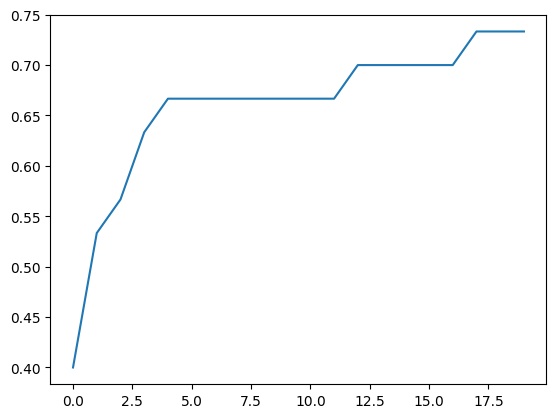

In [22]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'accuracy_display'))

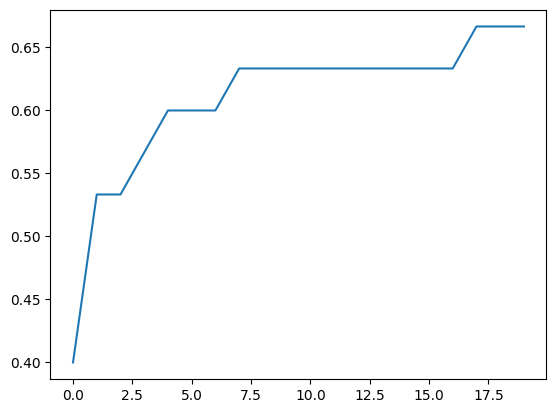

In [23]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'accuracy_test'))


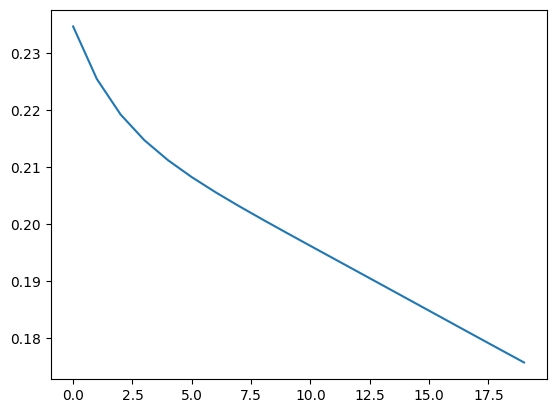

In [24]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'loss'))